## PD -Probability of Default

This notebook aims to come up with a general methodology for selecting features for PD model - as well as for finding the best categories for the features.

### Packages

Here we are going to import some packages for the whole development, as well as our own package, so that we can iterate faster on its functionalities.

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data

We are going to work with data that we've previously cleaned and preprocessed.

In [2]:
df = pd.read_csv("../data/loan_data_cleaned.csv")
df.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,...,verification_status,initial_list_status,inq_last_6mths,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim,months_since_issue_date,months_since_earliest_cr_line
0,1077501,1296599,5000,5000,36,10.65,162.87,B,10.0,RENT,...,Verified,f,1.0,3.0,0.0,9.0,0.0,NaN,72.017906,394.981416
1,1077430,1314167,2500,2500,60,15.27,59.83,C,0.0,RENT,...,Source Verified,f,5.0,3.0,0.0,4.0,0.0,NaN,72.017906,224.037455
2,1077175,1313524,2400,2400,36,15.96,84.33,C,10.0,RENT,...,Not Verified,f,2.0,2.0,0.0,10.0,0.0,NaN,72.017906,192.989589
3,1076863,1277178,10000,10000,36,13.49,339.31,C,10.0,RENT,...,Source Verified,f,1.0,10.0,0.0,37.0,0.0,NaN,72.017906,261.984846
4,1075358,1311748,3000,3000,60,12.69,67.79,B,1.0,RENT,...,Source Verified,f,0.0,15.0,0.0,38.0,0.0,NaN,72.017906,263.003347


### Methodology

PD models need to be **explainable and interpretable**, according to regulators' requirements. Hence, the best approach for this issue is to develop a **credit scorecard**. Hence, we need to have appropriate categories and their corresponding increases/decreases in the Credit Score.

This means that we will work with categorical variables and binned numeric variables. Moreover, since some of the variables might have high cardinality, it might be useful for us to understand how the categories behave with respect to the target variable, and aggregate some of them whenever reasonable.

+ Target Variable

First of all, let's define our target variable accordingly. There are several categories under `loan_status`, however we need to encode it accordingly, in a way that 0 corresponds to non-default and 1 to default.

In [3]:
df["loan_status"].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [4]:
DEFAULT_CATEGORIES = [
    "Charged Off",
    "Late (31-120 days)",
    "Default",
    "Does not meet the credit policy. Status:Charged Off"
]

df["default"] = df["loan_status"].isin(DEFAULT_CATEGORIES).astype(float)
(df["default"].value_counts() / len(df)).apply(lambda x: f"{100*x:.2f}%")

0.0    89.07%
1.0    10.93%
Name: default, dtype: object

+ **Weight of Evidence (WoE)**

WoE shows us to what extent an independent variable would predict a dependent one. It is computed for every single category within a variable, according to the following formula:

$WoE_i = \ln{\frac{\%(y=1)_i}{\%(y=0)_i}}$

The further away from zero, the better the category in differentiating between classes.

When using WoE to analyze discrete variables, before choosing appropriate categories, it is important to have the proportion of observations also available, given that **we can combine underrepresented categories**. On the other hand, if a given category stands out, then it should be kept as a single category.

+ **Information Value (IV)**

On top of WoE, it is possible to compute IV, which represent how much information the original independent variable brings with respect to explaining the dependent variable.

Usually, IV is applied fo feature selection:

| IV  | Meaning  |
|---|---|
|< 0.02   |  No predictive power |
|0.02 < IV < 0.1   | Weak predictive power   |
|0.1 < IV < 0.3   | Medium predictive power   |
|0.3 < IV < 0.5   | Strong predictive power   |
|IV > 0.5   | Suspicious... Too good to be true   |

Defining a function for computing WoE for each category within a variable will make our lives easier. Also, a function to display results in a graphical manner will be quite useful.

In [5]:
def compute_woe(
    df: pd.DataFrame,
    id_column_name: str,
    feature_column_name: str,
    target_column_name: str,
    sort_by_woe: bool = True
) -> pd.DataFrame:
    # GENERATE CONTINGENCY MATRIX
    matrix = pd.pivot_table(
        data=df,
        index=feature_column_name,
        columns=target_column_name,
        values=id_column_name,
        aggfunc=pd.Series.count
    )
    label_columns = ["Non-Default", "Default"]
    matrix.columns = label_columns
    
    # COMPUTE WOE
    matrix["Total Obs"] = matrix.sum(axis=1)
    for label in label_columns:
        matrix[f"% {label}"] = matrix[label] / matrix[label].sum()
    matrix["WoE"] = np.log(matrix[f"% {label_columns[1]}"] / matrix[f"% {label_columns[0]}"])
    
    # COMPUTE IV
    matrix["IV"] = (matrix["WoE"] * (matrix[f"% {label_columns[1]}"] - matrix[f"% {label_columns[0]}"])).sum()
    
    # SORT BY WOE OR FEATURE VALUE
    if sort_by_woe:
        matrix = matrix.sort_values(by="WoE")
    return matrix

In [6]:
def plot_woe_by_category(
    df: pd.DataFrame,
    rotate: bool = False
) -> None:
    woe_column = "WoE"
    _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(df.index, df[woe_column], "o--", color="black")
    ax.set_xlabel(df.index.name.capitalize())
    if rotate:
        plt.xticks(rotation=90)
    ax.set_ylabel(woe_column)
    plt.grid(alpha=0.3, linestyle="--")
    plt.show()

In [7]:
woe = compute_woe(
    df=df,
    id_column_name="id",
    feature_column_name="grade",
    target_column_name="default",
    sort_by_woe=True,
)
woe

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
grade,,,,,,,
A,71970,2897,74867,0.173289,0.056840,-1.114730,0.290782
B,126170,10759,136929,0.303792,0.211093,-0.364043,0.290782
C,110909,14384,125293,0.267047,0.282216,0.055251,0.290782
D,65040,11848,76888,0.156603,0.232460,0.395001,0.290782
E,28793,6964,35757,0.069328,0.136635,0.678466,0.290782
F,10037,3192,13229,0.024167,0.062628,0.952214,0.290782
G,2398,924,3322,0.005774,0.018129,1.144166,0.290782


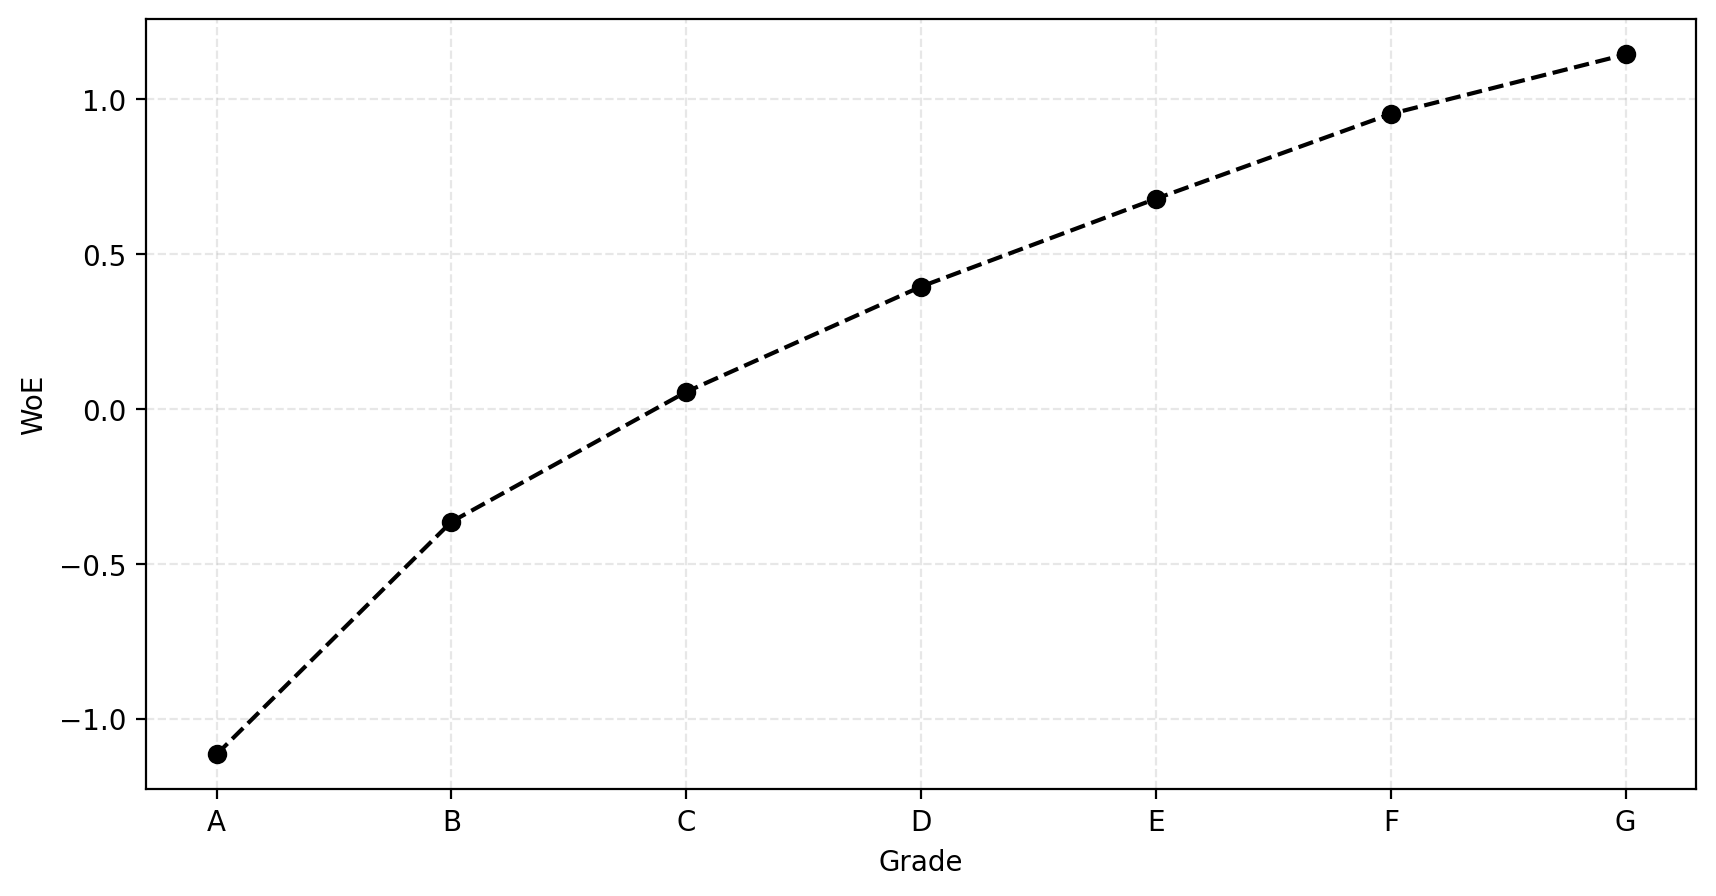

In [8]:
plot_woe_by_category(woe, rotate=False)